# Modeling

### Import Libaries

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import time

from scipy.stats import randint
from sklearn import __version__ as sklearn_version
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (make_scorer,accuracy_score, auc, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, f1_score, mean_absolute_error,
                             mean_squared_error, precision_score, r2_score, recall_score, roc_curve,roc_auc_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, cross_val_score,
                                     cross_validate, learning_curve, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from joblib import Parallel, delayed
import multiprocessing


### Load Data

In [2]:
datafilepath = "../data/interim/train_test_split.pkl"

with open(datafilepath, 'rb') as file:
    X,y,X_train, X_test, y_train, y_test = pickle.load(file)

In [3]:
X_train

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,Cluster,MaritalStatus_No,...,CityCode_SEW,CityCode_SFR,CityCode_SFU,CityCode_SHE,CityCode_SLC,CityCode_SLU,CityCode_STL,CityCode_VAH,ChildrenInHH_No,ChildrenInHH_Yes
10995,49.01,220.0,24.0,0.00,0.0,0.0,3.7,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14784,166.82,706.0,60.0,2.97,153.0,0.0,3.3,0,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10258,35.45,215.0,45.0,0.00,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
44546,10.20,39.0,10.0,0.00,0.0,0.1,0.0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
48450,58.80,708.0,70.0,0.00,0.0,0.8,2.3,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,52.63,526.0,60.0,0.00,0.0,2.6,0.0,4,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45891,29.99,113.0,30.0,0.00,0.0,0.0,0.0,8,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
42613,39.30,166.0,40.0,1.49,10.0,1.7,0.3,7,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
43567,10.00,0.0,10.0,0.00,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Initiation

In [4]:
#Calculate the mean of `y_train`
train_mean = y_train.mean()
train_mean

0.2896392976957171

In [5]:
#Calculate the medium of `y_train`
X_defaults_median = X_train.median()
X_defaults_median

MonthlyRevenue            48.46
MonthlyMinutes           366.00
TotalRecurringCharge      45.00
DirectorAssistedCalls      0.25
OverageMinutes             3.00
                          ...  
CityCode_SLU               0.00
CityCode_STL               0.00
CityCode_VAH               0.00
ChildrenInHH_No            1.00
ChildrenInHH_Yes           0.00
Length: 79, dtype: float64

#### Impute NaN Data

In [6]:
# Check for NaN values
print("NaN values in X_test:", X_test.isna().sum().sum())
print("NaN values in X:", X.isna().sum().sum())

# Replace NaN values with the mean (you can choose other methods)
X_test = X_test.fillna(X_test.mean())
#X=X.fillna(X.mean())

# Check for infinity values
print("Infinity values in X_test:", np.isinf(X_test).sum().sum())
#print("Infinity values in X:", np.isinf(X).sum().sum())

# Replace infinity values
X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.mean())
#X= X.replace([np.inf, -np.inf], np.nan).fillna(X.mean())

NaN values in X_test: 0
NaN values in X: 0
Infinity values in X_test: 0


#### Normalize or Scale your data

In [7]:
#scaler = StandardScaler()
#X_test = scaler.fit_transform(X_test)
#X_test

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Models

#### Initialize models with hyper-parameter tuning and resampling methods.

In [8]:
models = {
    "Decision Tree": (DecisionTreeClassifier(random_state=0), {"max_depth": [None, 5, 10]}),
    "Random Forest": (RandomForestClassifier(random_state=0), {"n_estimators": [10, 50], "max_depth": [None, 10]}),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=0), {"learning_rate": [0.1, 0.2], "n_estimators": [50, 100]}),
    "Neural Network": (MLPClassifier(max_iter=1000,tol=1e-4, random_state=0), {"hidden_layer_sizes": [(50,), (100,)], "learning_rate_init": [0.001, 0.01]}),
    "KNN": (KNeighborsClassifier(), {"n_neighbors": [3, 5]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0), {"n_estimators": [50, 100], "learning_rate": [0.1, 0.2]})
}

<b>Handling Imbalance Data </b></br> As dataset contains more Non-churn customers,One of the resampling techniques will be considered to use to balance out the data for both Churn and Non-Churn categories. It will help the prediction results in a more balanced dataset that allows the model to learn more effectively from both classes, improving its accuracy and predictive performance on unseen data.

In [9]:
resampling_methods = {
    "Under Sampling": RandomUnderSampler(random_state=0),
    "SMOTEENN": SMOTEENN(random_state=0),
    "Over Sampling": RandomOverSampler(random_state=0),
}

#### Train Models

In [10]:

def train_model_and_evaluate(name, model, params, X_train, y_train, X_test, y_test, resampling_name, resampler):
    start_time = time.time()
    current_time = datetime.now()
    print('Started at:', current_time.strftime("%H:%M:%S"))
    print('Model Name:', name, 'Resampling Method:', resampling_name)
    print('----------------------------------')
    try:
        # Resampling
        X_resampled, y_resampled = resampler.fit_resample(X_train_scaled, y_train)
        
        # GridSearchCV setup with custom scoring
        scoring = {'AUC': make_scorer(roc_auc_score)}
        grid_search = GridSearchCV(model, params, cv=5, scoring=scoring, refit='AUC')
        grid_search.fit(X_resampled, y_resampled)
        
        # Best model from GridSearch
        best_model = grid_search.best_estimator_
        best_score = grid_search.best_score_
        
        # Predictions and evaluations
        y_pred = best_model.predict(X_test_scaled)
        y_scores = best_model.predict_proba(X_test_scaled)[:, 1]
        roc_auc = roc_auc_score(y_test, y_scores)
        accuracy = accuracy_score(y_test, y_pred)
        cv_scores = cross_val_score(best_model, X_resampled, y_resampled, cv=5).mean()
        
        class_report = classification_report(y_test, y_pred)
        lines = class_report.split('\n')
        summary_metrics = lines[-2].split()

        cm = confusion_matrix(y_test, y_pred).tolist()  # Convert to list for DataFrame compatibility
        
        # Constructing result dictionary
        result = {
            'Model Name': name,
            'Resampling Method': resampling_name,
            'ROC AUC': roc_auc,
            'Best Score':best_score,
            'Accuracy': accuracy,
            'CV Score': cv_scores,
            'CalssificationReport':class_report,
            "Precision": summary_metrics[2],
            "Recall": summary_metrics[3],
            "F1-score": summary_metrics[4],
            'Confusion Matrix': cm
        }
        
    except Exception as e:
        result = {
            'Model Name': name,
            'Resampling Method': resampling_name,
            'Error': str(e)
        }
        
    print('----------------------------------')
    elapsed_time = (time.time() - start_time) / 60
    print("Elapsed time: {:.2f} minutes".format(elapsed_time))
    return result



In [11]:
# Prepare for parallel execution
num_cores = multiprocessing.cpu_count()

In [12]:
# Execute training and evaluation in parallel for all models and resampling methods
results = Parallel(n_jobs=num_cores)(
    delayed(train_model_and_evaluate)(
        name, model, params, X_train_scaled, y_train, X_test_scaled, y_test, resampling_name, resampler
    ) 
    for resampling_name, resampler in resampling_methods.items()
    for name, (model, params) in models.items()
)

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

results_df

Started at: 09:24:50
Model Name: Random Forest Resampling Method: Under Sampling
----------------------------------
----------------------------------
Elapsed time: 0.81 minutes
Started at: 09:25:38
Model Name: KNN Resampling Method: SMOTEENN
----------------------------------
----------------------------------
Elapsed time: 4.43 minutes
Started at: 09:30:04
Model Name: XGBoost Resampling Method: Over Sampling
----------------------------------
----------------------------------
Elapsed time: 1.25 minutes
Started at: 09:24:50
Model Name: Decision Tree Resampling Method: SMOTEENN
----------------------------------
----------------------------------
Elapsed time: 2.77 minutes
Started at: 09:27:36
Model Name: Decision Tree Resampling Method: Over Sampling
----------------------------------
----------------------------------
Elapsed time: 0.44 minutes
Started at: 09:28:03
Model Name: Random Forest Resampling Method: Over Sampling
----------------------------------
-------------------------

,Model Name,Resampling Method,ROC AUC,Best Score,Accuracy,CV Score,CalssificationReport,Precision,Recall,F1-score,Confusion Matrix
0,Decision Tree,Under Sampling,0.568658,0.545659,0.618022,0.545654,precision recall f1-score ...,0.64,0.62,0.63,"[[5152, 2175], [1725, 1158]]"
1,Random Forest,Under Sampling,0.589827,0.554194,0.573164,0.554193,precision recall f1-score ...,0.64,0.57,0.59,"[[4302, 3025], [1333, 1550]]"
2,Gradient Boosting,Under Sampling,0.591060,0.558843,0.580118,0.558843,precision recall f1-score ...,0.65,0.58,0.60,"[[4393, 2934], [1353, 1530]]"
3,Neural Network,Under Sampling,0.550152,0.529212,0.548090,0.529210,precision recall f1-score ...,0.62,0.55,0.57,"[[4110, 3217], [1397, 1486]]"
4,KNN,Under Sampling,0.531363,0.513061,0.526543,0.513062,precision recall f1-score ...,0.62,0.53,0.55,"[[3854, 3473], [1361, 1522]]"
5,XGBoost,Under Sampling,0.589394,0.558420,0.577179,0.558420,precision recall f1-score ...,0.64,0.58,0.60,"[[4366, 2961], [1356, 1527]]"
6,Decision Tree,SMOTEENN,0.530061,0.712893,0.564055,0.729819,precision recall f1-score ...,0.62,0.56,0.58,"[[4456, 2871], [1580, 1303]]"
7,Random Forest,SMOTEENN,0.569639,0.814644,0.576298,0.837825,precision recall f1-score ...,0.63,0.58,0.60,"[[4465, 2862], [1464, 1419]]"
8,Gradient Boosting,SMOTEENN,0.573355,0.740297,0.577669,0.751634,precision recall f1-score ...,0.64,0.58,0.60,"[[4445, 2882], [1430, 1453]]"
9,Neural Network,SMOTEENN,0.546850,0.809058,0.501469,0.835769,precision recall f1-score ...,0.62,0.50,0.52,"[[3358, 3969], [1121, 1762]]"


In [13]:
results_df

,Model Name,Resampling Method,ROC AUC,Best Score,Accuracy,CV Score,CalssificationReport,Precision,Recall,F1-score,Confusion Matrix
0,Decision Tree,Under Sampling,0.568658,0.545659,0.618022,0.545654,precision recall f1-score ...,0.64,0.62,0.63,"[[5152, 2175], [1725, 1158]]"
1,Random Forest,Under Sampling,0.589827,0.554194,0.573164,0.554193,precision recall f1-score ...,0.64,0.57,0.59,"[[4302, 3025], [1333, 1550]]"
2,Gradient Boosting,Under Sampling,0.591060,0.558843,0.580118,0.558843,precision recall f1-score ...,0.65,0.58,0.60,"[[4393, 2934], [1353, 1530]]"
3,Neural Network,Under Sampling,0.550152,0.529212,0.548090,0.529210,precision recall f1-score ...,0.62,0.55,0.57,"[[4110, 3217], [1397, 1486]]"
4,KNN,Under Sampling,0.531363,0.513061,0.526543,0.513062,precision recall f1-score ...,0.62,0.53,0.55,"[[3854, 3473], [1361, 1522]]"
5,XGBoost,Under Sampling,0.589394,0.558420,0.577179,0.558420,precision recall f1-score ...,0.64,0.58,0.60,"[[4366, 2961], [1356, 1527]]"
6,Decision Tree,SMOTEENN,0.530061,0.712893,0.564055,0.729819,precision recall f1-score ...,0.62,0.56,0.58,"[[4456, 2871], [1580, 1303]]"
7,Random Forest,SMOTEENN,0.569639,0.814644,0.576298,0.837825,precision recall f1-score ...,0.63,0.58,0.60,"[[4465, 2862], [1464, 1419]]"
8,Gradient Boosting,SMOTEENN,0.573355,0.740297,0.577669,0.751634,precision recall f1-score ...,0.64,0.58,0.60,"[[4445, 2882], [1430, 1453]]"
9,Neural Network,SMOTEENN,0.546850,0.809058,0.501469,0.835769,precision recall f1-score ...,0.62,0.50,0.52,"[[3358, 3969], [1121, 1762]]"


##### Models Comparison

In [43]:

    
for index, row in results_df.iterrows():
    print(row['Model Name'])
    print(row['Resampling Method'])
    print (row['CalssificationReport'])

Decision Tree
Under Sampling
              precision    recall  f1-score   support

           0       0.75      0.70      0.73      7327
           1       0.35      0.40      0.37      2883

    accuracy                           0.62     10210
   macro avg       0.55      0.55      0.55     10210
weighted avg       0.64      0.62      0.63     10210

Random Forest
Under Sampling
              precision    recall  f1-score   support

           0       0.76      0.59      0.66      7327
           1       0.34      0.54      0.42      2883

    accuracy                           0.57     10210
   macro avg       0.55      0.56      0.54     10210
weighted avg       0.64      0.57      0.59     10210

Gradient Boosting
Under Sampling
              precision    recall  f1-score   support

           0       0.76      0.60      0.67      7327
           1       0.34      0.53      0.42      2883

    accuracy                           0.58     10210
   macro avg       0.55      0.57    

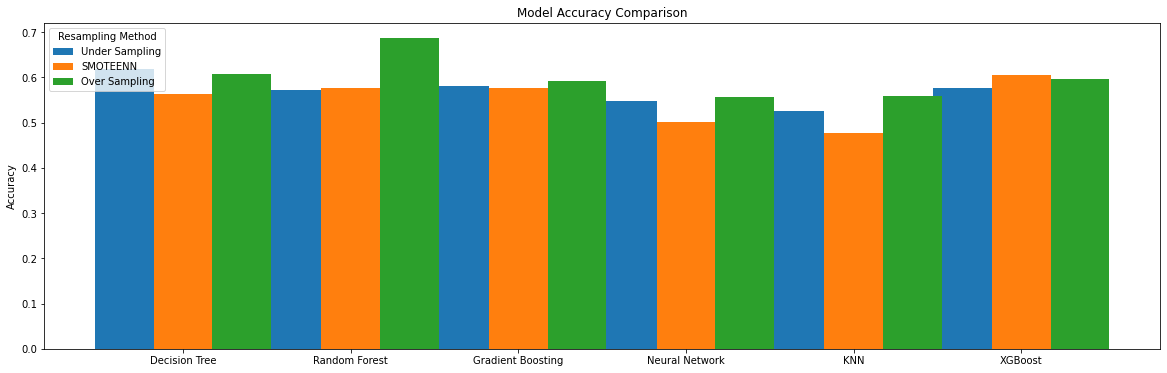

In [14]:
# Plot setup
model_names = results_df['Model Name'].unique()
methods = results_df['Resampling Method'].unique()
n_methods = len(methods)

fig, ax = plt.subplots(figsize=(20, 6))
width = 0.35  # Width of the bars

# Calculate the positions for each group
model_positions = np.arange(len(model_names))

for i, method in enumerate(methods):
    # Calculate offset for each method
    offsets = model_positions + (i - np.floor(n_methods / 2)) * width
    # Subset DataFrame for the method
    df_subset = results_df[results_df['Resampling Method'] == method]
    # Plot each method's bar with an offset
    ax.bar(offsets, df_subset['Accuracy'], width, label=method)

ax.set_title('Model Accuracy Comparison')
ax.set_ylabel('Accuracy')
ax.set_xticks(model_positions)
ax.set_xticklabels(model_names)
ax.legend(title='Resampling Method')

plt.show()

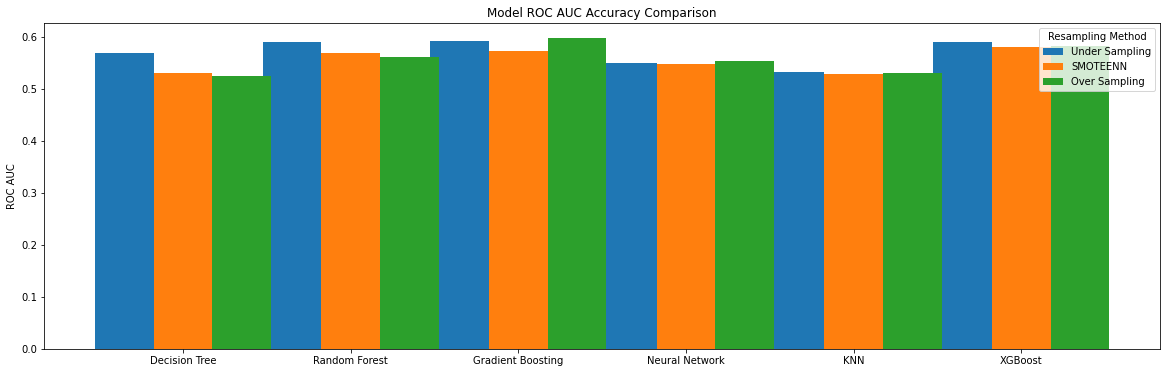

In [38]:
# Plot setup
model_names = results_df['Model Name'].unique()
methods = results_df['Resampling Method'].unique()
n_methods = len(methods)

fig, ax = plt.subplots(figsize=(20, 6))
width = 0.35  # Width of the bars

# Calculate the positions for each group
model_positions = np.arange(len(model_names))

for i, method in enumerate(methods):
    # Calculate offset for each method
    offsets = model_positions + (i - np.floor(n_methods / 2)) * width
    # Subset DataFrame for the method
    df_subset = results_df[results_df['Resampling Method'] == method]
    # Plot each method's bar with an offset
    ax.bar(offsets, df_subset['ROC AUC'], width, label=method)

ax.set_title('Model ROC AUC Accuracy Comparison')
ax.set_ylabel('ROC AUC')
ax.set_xticks(model_positions)
ax.set_xticklabels(model_names)
ax.legend(title='Resampling Method')

plt.show()

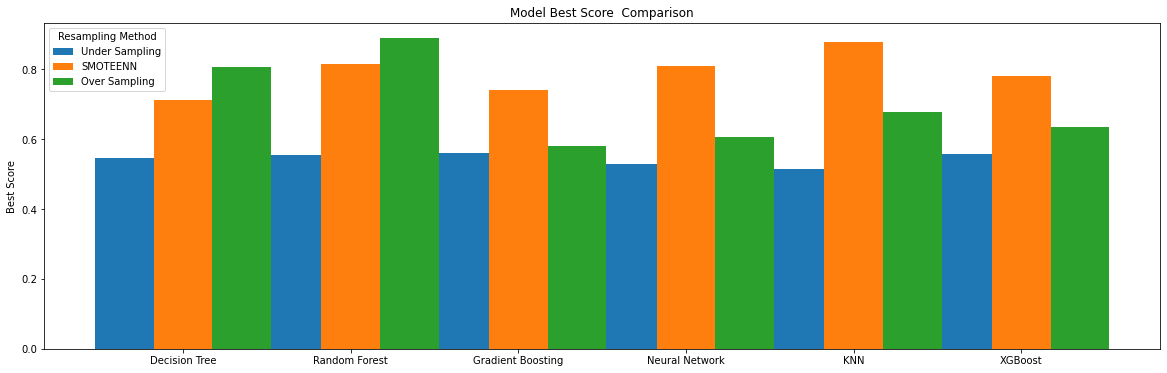

In [39]:
# Plot setup
model_names = results_df['Model Name'].unique()
methods = results_df['Resampling Method'].unique()
n_methods = len(methods)

fig, ax = plt.subplots(figsize=(20, 6))
width = 0.35  # Width of the bars

# Calculate the positions for each group
model_positions = np.arange(len(model_names))

for i, method in enumerate(methods):
    # Calculate offset for each method
    offsets = model_positions + (i - np.floor(n_methods / 2)) * width
    # Subset DataFrame for the method
    df_subset = results_df[results_df['Resampling Method'] == method]
    # Plot each method's bar with an offset
    ax.bar(offsets, df_subset['Best Score'], width, label=method)

ax.set_title('Model Best Score  Comparison')
ax.set_ylabel('Best Score')
ax.set_xticks(model_positions)
ax.set_xticklabels(model_names)
ax.legend(title='Resampling Method')

plt.show()

##### Lets see cross validation comparison

/Users/thantthiri/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


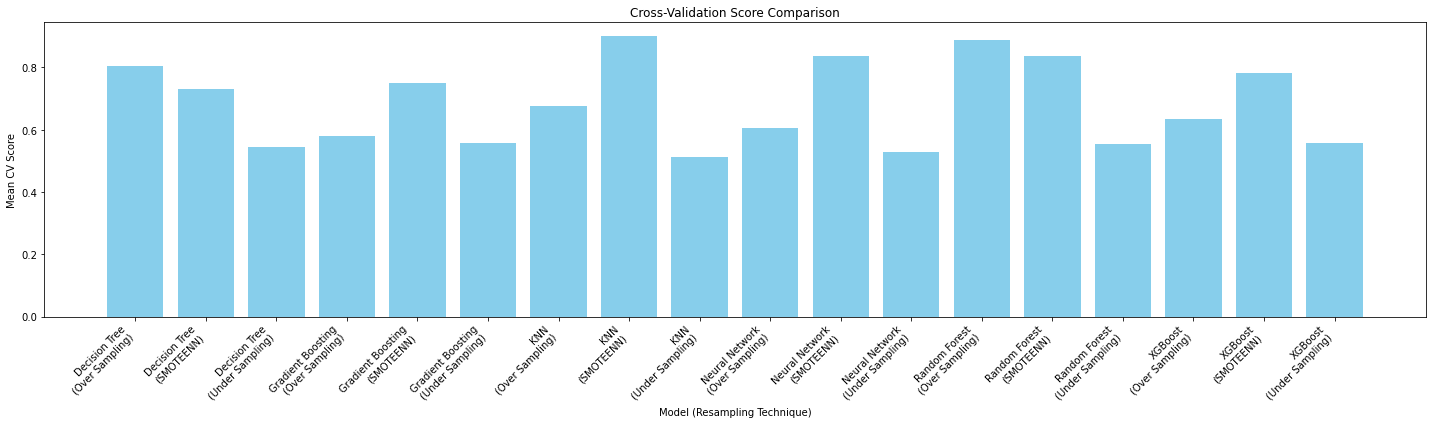

[('Decision Tree', 'Over Sampling', 0.8049925798350657, nan),
 ('Decision Tree', 'SMOTEENN', 0.7298191426355515, nan),
 ('Decision Tree', 'Under Sampling', 0.5456543172288746, nan),
 ('Gradient Boosting', 'Over Sampling', 0.5807508669782324, nan),
 ('Gradient Boosting', 'SMOTEENN', 0.751634107656043, nan),
 ('Gradient Boosting', 'Under Sampling', 0.5588432298397666, nan),
 ('KNN', 'Over Sampling', 0.6767218346192546, nan),
 ('KNN', 'SMOTEENN', 0.8996521720995846, nan),
 ('KNN', 'Under Sampling', 0.5130620716616521, nan),
 ('Neural Network', 'Over Sampling', 0.6062432414824073, nan),
 ('Neural Network', 'SMOTEENN', 0.8357692035043387, nan),
 ('Neural Network', 'Under Sampling', 0.5292100108401753, nan),
 ('Random Forest', 'Over Sampling', 0.8887254000654717, nan),
 ('Random Forest', 'SMOTEENN', 0.8378247748275471, nan),
 ('Random Forest', 'Under Sampling', 0.5541929519028196, nan),
 ('XGBoost', 'Over Sampling', 0.6360098273625165, nan),
 ('XGBoost', 'SMOTEENN', 0.783367561164303, nan),


In [16]:
# Grouping by model name and resampling method, then calculating mean and std of CV scores
grouped = results_df.groupby(["Model Name", "Resampling Method"])["CV Score"].agg(["mean", "std"]).reset_index()

# Extracting model names and resampling techniques directly from the grouped dataframe
model_names_from_df = grouped["Model Name"].tolist()
resampling_techs_from_df = grouped["Resampling Method"].tolist()
cv_means_from_df = grouped["mean"].tolist()
cv_stds_from_df = grouped["std"].tolist()

# Plotting using the extracted values
plt.figure(figsize=(20, 6))
plt.bar([f"{model}\n({resampling})" for model, resampling in zip(model_names_from_df, resampling_techs_from_df)], cv_means_from_df, yerr=cv_stds_from_df, capsize=5, color='skyblue')
plt.xlabel('Model (Resampling Technique)')
plt.ylabel('Mean CV Score')
plt.title('Cross-Validation Score Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Confirming the list
list(zip(model_names_from_df, resampling_techs_from_df, cv_means_from_df, cv_stds_from_df))

### Final Best Modeling

In [17]:
#final_model = GradientBoostingClassifier(random_state=0)
#final_model = KNeighborsClassifier()
final_model = RandomForestClassifier(random_state=0)
fparams = {"n_estimators": [10, 50], "max_depth": [None, 10]}
#name = "Gradient Boosting Classifier"
name = "Random Forest Classifier"

# Adding model metadata

final_model.version = '1.0'
final_model.pandas_version = pd.__version__
final_model.numpy_version = np.__version__
final_model.sklearn_version = sklearn_version
final_model.X_columns = [col for col in X_train.columns] 
final_model.build_datetime = datetime.now()

start_time = time.time()
current_time = datetime.now()
print('Started at: ', current_time.strftime("%H:%M:%S"))
print('Model Name: ',name)
print('----------------------------------')
    

resampler= RandomOverSampler(random_state=0)
X_resampled, y_resampled = resampler.fit_resample(X_train_scaled, y_train)
#final_model.fit(X_train_resampled, y_train_resampled)

scoring = {'AUC': make_scorer(roc_auc_score)}
grid_search = GridSearchCV(final_model, fparams, cv=5, scoring=scoring, refit='AUC')
grid_search.fit(X_resampled, y_resampled)
        
# Best model from GridSearch
final_model = grid_search.best_estimator_
final_best_score = grid_search.best_score_

final_pred = final_model.predict(scaler.fit_transform(X))
final_y_prob = final_model.predict_proba(scaler.fit_transform(X))[:, 1]  # Probability of class 1 (churn)
final_roc_auc = roc_auc_score(y, final_y_prob)
final_accuracy = accuracy_score(y, final_pred)
final_class_report = classification_report(y, final_pred)
final_cv_scores = cross_val_score(final_model, X, y, cv=5)
final_cm = confusion_matrix(y,final_pred)

final_model.cv_scores = final_cv_scores
final_model.mean_cv_score = final_cv_scores.mean()

print(f'CV Scores: {final_cv_scores}')
print(f'Best Scores: {final_best_score}')
print(f'Average CV Score: {final_cv_scores.mean()}')
print(f'Accurancy: {final_accuracy}')
print(f'ROC AUC: {final_roc_auc}')
print(f'Confusion Matrix: {final_cm}')
print(f'Report: {final_class_report}')


print('----------------------------------')
elapsed_time = (time.time() - start_time) / 60
print("Elapsed time: {:.2f} minutes".format(elapsed_time))

Started at:  10:01:10
Model Name:  Random Forest Classifier
----------------------------------
CV Scores: [0.70391773 0.70009794 0.70163581 0.70653345 0.70428054]
Best Scores: 0.8887254934293504
Average CV Score: 0.7032930940215317
Accurancy: 0.9360981056673262
ROC AUC: 0.971977294613936
Confusion Matrix: [[35614   722]
 [ 2540 12171]]
Report:               precision    recall  f1-score   support

           0       0.93      0.98      0.96     36336
           1       0.94      0.83      0.88     14711

    accuracy                           0.94     51047
   macro avg       0.94      0.90      0.92     51047
weighted avg       0.94      0.94      0.93     51047

----------------------------------
Elapsed time: 1.13 minutes
Started at: 09:24:50
Model Name: Gradient Boosting Resampling Method: Under Sampling
----------------------------------
----------------------------------
Elapsed time: 4.12 minutes
Started at: 09:28:57
Model Name: Neural Network Resampling Method: Over Sampling
--

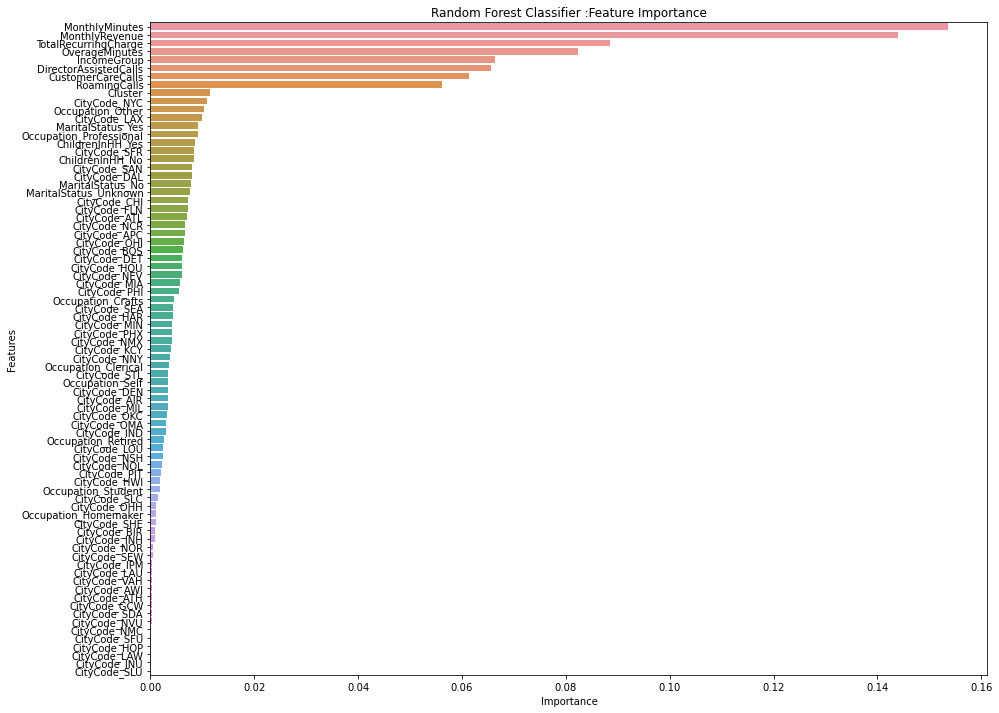

In [18]:
# Visualize Feature Importance
feature_importance = final_model.feature_importances_
feature_names = X_train.columns  # Adjust this based on your feature names

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Plot the feature importances
plt.figure(figsize=(15, 12))
sns.barplot(x=feature_importance[indices], y=feature_names[indices])
plt.title(f'{name} :Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



<b>Confusion Matrix</b> </br>
True Negative (TN): cm[0, 0] - Actual negatives that were predicted as negative</br>
False Positive (FP): cm[0, 1] - Actual negatives that were predicted as positive</br>
False Negative (FN): cm[1, 0] - Actual positives that were predicted as negative</br>
True Positive (TP): cm[1, 1] - Actual positives that were predicted as positive</br>

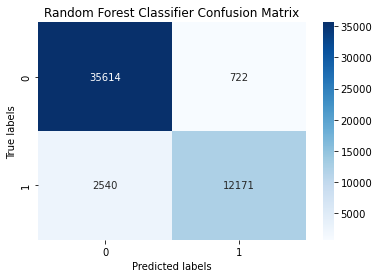

In [19]:
sns.heatmap(final_cm, annot=True, fmt="d", cmap="Blues")
plt.title(f'{name} Confusion Matrix')  
plt.xlabel('Predicted labels') 
plt.ylabel('True labels')  
plt.show()

Above Confusion Matrix suggests that that the classifier has a high degree of accuracy and precision with a reasonably high recall. The F1 score being closer to 1 is indicative of a good balance between precision and recall, which is particularly important in cases where there is an imbalance between the positive and negative classes. 

Lets see ROC curve.

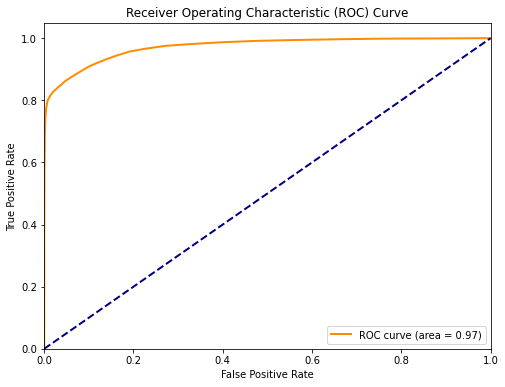

In [20]:
fpr, tpr, thresholds = roc_curve(y, final_y_prob)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The AUC value ranges from 0 to 1:</br>

An AUC of 0.5 suggests no discriminative ability, equivalent to random guessing.</br>
An AUC of 1.0 represents perfect discrimination, where the classifier can perfectly differentiate between the two classes.</br>
An AUC less than 0.5 suggests worse than random predictions, but this is typically observed only when there's a problem with the way the classifier is being used.</br>
The graph suggests an AUC of 0.97 indicates a very good predictive model with high sensitivity and specificity. 

In [21]:
final_pred

array([1, 0, 0, ..., 1, 0, 0])

In [25]:
df_pred =X.copy()
df_pred['ChurnPredicted'] = final_pred
df_pred['Churn'] = y

In [26]:
df_pred[df_pred['ChurnPredicted']==0]

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,Cluster,MaritalStatus_No,...,CityCode_SFU,CityCode_SHE,CityCode_SLC,CityCode_SLU,CityCode_STL,CityCode_VAH,ChildrenInHH_No,ChildrenInHH_Yes,ChurnPredicted,Churn
1,16.99,10.0,17.0,0.00,0.0,0.0,0.0,5,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,1
2,38.00,8.0,38.0,0.00,0.0,0.0,0.0,6,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
3,82.28,1312.0,75.0,1.24,0.0,0.0,4.3,6,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
5,38.05,682.0,52.0,0.25,0.0,0.0,0.7,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
6,31.66,26.0,30.0,0.25,0.0,0.0,0.0,9,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51039,50.00,492.0,50.0,0.00,0.0,0.0,0.3,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
51040,71.99,724.0,70.0,0.00,4.0,0.9,0.0,7,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
51043,95.17,1745.0,85.0,0.99,45.0,4.7,0.0,9,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
51045,48.46,366.0,45.0,0.25,3.0,0.0,0.0,9,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0


In [27]:
prediction = df_pred['ChurnPredicted'].value_counts().sort_index()
prediction

0    38154
1    12893
Name: ChurnPredicted, dtype: int64

##### Save Model File

In [28]:
save_modelfilepath = "../models/final_model.pkl"
with open(save_modelfilepath, 'wb') as file:
    pickle.dump([final_model], file)

#### Post-Classification Analysis

Using churn probabilities from the classification model to further segment customers based on their risk of churning. This segmentation can help in strategizing targeted interventions for different risk groups. </br>
Low Risk (p < 0.3)</br>
Medium Risk (0.3 ≤ p < 0.7)</br>
High Risk (p ≥ 0.7)

In [29]:
risk_segments = np.digitize(final_y_prob, bins=[0.3, 0.7])

#X_risk = X.copy()

df_pred['ChurnProbability'] = final_y_prob
df_pred['RiskSegment'] = risk_segments

# Analyze the distribution of risk segments
risk_segment_distribution = df_pred['RiskSegment'].value_counts().sort_index()
risk_segment_distribution

0    31238
1     9074
2    10735
Name: RiskSegment, dtype: int64

### Recommandation

Implement Targeted Strategies Based on Risk Segmentation

In [30]:
def implement_targeted_strategies(df):
    # Define strategies for each risk segment
    strategies = {
        0: "Send personalized emails offering discounts or special offers.",
        1: "Engage with customer service for feedback and improvement suggestions.",
        2: "Offer loyalty programs or benefits to enhance customer retention."
    }
    
    df['RetentionStrategy'] = df['RiskSegment'].map(strategies)
    
    # Example: Executing strategies (this could be more complex in practice)
    for segment, strategy in strategies.items():
        customers = df[df['RiskSegment'] == segment]
        print(f"Segment {segment}: {len(customers)} customers")
        print(f"Strategy: {strategy}\n")

In [31]:
implement_targeted_strategies(df_pred)

Segment 0: 31238 customers
Strategy: Send personalized emails offering discounts or special offers.

Segment 1: 9074 customers
Strategy: Engage with customer service for feedback and improvement suggestions.

Segment 2: 10735 customers
Strategy: Offer loyalty programs or benefits to enhance customer retention.



### Encode the Data

In [32]:
# assume that the prefix before the last underscore in each column name represents the original variable name
# Extract the prefix of each one-hot encoded column

encoded_columns = [col for col in df_pred.columns if '_' in col]  # Consider only columns with '_' in their names
prefixes = set(col.rsplit('_', 1)[0] for col in encoded_columns)
categorical_mappings = {prefix: [col for col in encoded_columns if col.startswith(prefix)] for prefix in prefixes}

categorical_mappings

{'Occupation': ['Occupation_Clerical',
  'Occupation_Crafts',
  'Occupation_Homemaker',
  'Occupation_Other',
  'Occupation_Professional',
  'Occupation_Retired',
  'Occupation_Self',
  'Occupation_Student'],
 'MaritalStatus': ['MaritalStatus_No',
  'MaritalStatus_Unknown',
  'MaritalStatus_Yes'],
 'CityCode': ['CityCode_AIR',
  'CityCode_APC',
  'CityCode_ATH',
  'CityCode_ATL',
  'CityCode_AWI',
  'CityCode_BIR',
  'CityCode_BOS',
  'CityCode_CHI',
  'CityCode_DAL',
  'CityCode_DEN',
  'CityCode_DET',
  'CityCode_FLN',
  'CityCode_GCW',
  'CityCode_HAR',
  'CityCode_HOP',
  'CityCode_HOU',
  'CityCode_HWI',
  'CityCode_IND',
  'CityCode_INH',
  'CityCode_INU',
  'CityCode_IPM',
  'CityCode_KCY',
  'CityCode_LAU',
  'CityCode_LAW',
  'CityCode_LAX',
  'CityCode_LOU',
  'CityCode_MIA',
  'CityCode_MIL',
  'CityCode_MIN',
  'CityCode_NCR',
  'CityCode_NEV',
  'CityCode_NMC',
  'CityCode_NMX',
  'CityCode_NNY',
  'CityCode_NOL',
  'CityCode_NOR',
  'CityCode_NSH',
  'CityCode_NVU',
  'Ci

In [33]:
# Decoding the one-hot encoded columns into the original categorical data
decoded_data = df_pred.copy()

# Note: 'Churn' mapping was mistakenly captured and will be disregarded for the main issue
excluded_churn = {k: v for k, v in categorical_mappings.items() if k != 'Churn'}
decoded_columns = []

for prefix, columns in excluded_churn.items():
    column_name = prefix
    decoded_data[column_name] = decoded_data[columns].idxmax(axis=1).str.replace(f'{prefix}_', '')
    decoded_columns.append(column_name)
    

encoded_columns_to_drop = [col for cols in excluded_churn.values() for col in cols]
decoded_data_preview = decoded_data.drop(columns=encoded_columns_to_drop)
decoded_data_preview

,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,CustomerCareCalls,IncomeGroup,Cluster,ChurnPredicted,Churn,ChurnProbability,RiskSegment,RetentionStrategy,Occupation,MaritalStatus,CityCode,ChildrenInHH
0,24.00,219.0,22.0,0.25,0.0,0.0,0.0,4,1,1,1,0.700000,2,Offer loyalty programs or benefits to enhance ...,Professional,No,SEA,No
1,16.99,10.0,17.0,0.00,0.0,0.0,0.0,5,1,0,1,0.380000,1,Engage with customer service for feedback and ...,Professional,Yes,PIT,Yes
2,38.00,8.0,38.0,0.00,0.0,0.0,0.0,6,1,0,0,0.200000,0,Send personalized emails offering discounts or...,Crafts,Yes,MIL,Yes
3,82.28,1312.0,75.0,1.24,0.0,0.0,4.3,6,0,0,0,0.280000,0,Send personalized emails offering discounts or...,Other,No,PIT,No
4,17.14,0.0,17.0,0.00,0.0,0.0,0.0,9,1,1,1,0.820000,2,Offer loyalty programs or benefits to enhance ...,Professional,Yes,OKC,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51042,48.46,366.0,45.0,0.25,3.0,0.0,0.0,6,0,1,1,0.531563,1,Engage with customer service for feedback and ...,Other,Yes,LAX,No
51043,95.17,1745.0,85.0,0.99,45.0,4.7,0.0,9,2,0,0,0.100000,0,Send personalized emails offering discounts or...,Other,No,LAX,Yes
51044,48.46,366.0,45.0,0.25,3.0,0.0,1.3,7,1,1,1,0.840000,2,Offer loyalty programs or benefits to enhance ...,Clerical,No,LAX,No
51045,48.46,366.0,45.0,0.25,3.0,0.0,0.0,9,1,0,0,0.180000,0,Send personalized emails offering discounts or...,Other,No,NEV,Yes


In [34]:
preddata_filepath = "../data/processed/pred_result.csv"
decoded_data_preview.to_csv(preddata_filepath, index=False) 